In [1]:
import numpy as np
data = open('data.txt', 'r').read()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
char_to_idx = { ch:i for i, ch in enumerate(chars) }
idx_to_char = { i:ch for i, ch in enumerate(chars) }

X_train = np.zeros((data_size, vocab_size))
X_train[np.arange(data_size), 
        [char_to_idx[char] for char in data]
       ] = 1

In [2]:
all_characters = ''.join(chars)
n_characters = len(all_characters)

In [3]:
chunk_len = 200

def random_chunk():
    from random import randint
    start_index = randint(0, data_size - chunk_len)
    end_index = start_index + chunk_len + 1
    return data[start_index:end_index]

print(random_chunk())

d thoughtfully, but without moving so that he would not miss any word of the conversation. "Well I can't think of any other way of explaining it, Mrs. Samsa", said the chief clerk, "I hope it's nothing


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

To make inputs out of this big string of data, we will be splitting it into chunks.

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [5]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([28,  5,  1, 72, 58, 71])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [6]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [7]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [8]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [13]:
def train(inp, target, model):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c].view(1))

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [14]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(), decoder)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/home/leoni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


 12s (100 5%) 2.1256]
Wher an to anly wa and oof of was his wilund and heat hit in hit st the wher ant stiwit what sth whed  

 27s (200 10%) 2.0508]
When of the cort, frout to wor his ention wound mad ely sith, for hime in of ther groom feme of wournc 

 38s (300 15%) 1.7918]
Wher the madive bebat the need under Sausenthis hat the the's onter, had the sell of the roen the cont 

 48s (400 20%) 1.6459]
Wherts he work, splad a dirsoormy ben the land to des ove in hear stay have ther and hou on had ank of 

 58s (500 25%) 1.7039]
Whive and sees. Guteng.

He despit cay guthe measins she tafker and had rest. "Ik in feen the as and s 

 8s (600 30%) 1.9536]
Whe the com( respill a beent fister, to griven fle fel streed they his for the clage instiln five from 

 19s (700 35%) 1.5509]
Wheed begrang all stand on lay her was isle looked fort there lem anthonger. Able from the cames the t 

 31s (800 40%) 1.7266]
Whe the even he really no eady to his room would bed a day undes and hous". where l

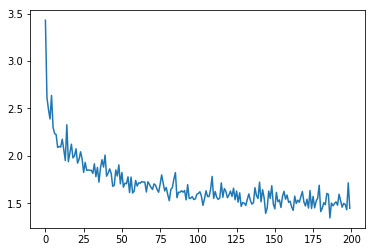

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)